In [ ]:
!pip install opendatasets

In [ ]:
dataset_link = "https://www.kaggle.com/datasets/arjuntejaswi/plant-village/download?datasetVersionNumber=1"

In [ ]:
import opendatasets as od
od.download(dataset_link)

100%|██████████| 329M/329M [00:01<00:00, 184MB/s]


In [ ]:
data_path = "/content/plant-village/PlantVillage"

In [ ]:
import os
import shutil

# Define the root directory
root_dir = data_path

# Define the directories to keep
keep_dirs = ["Potato___Early_blight", "Potato___Late_blight", "Potato___healthy"]

# Get a list of all directories in the root directory
all_dirs = next(os.walk(root_dir))[1]

# Delete directories other than the ones to keep
for dir_name in all_dirs:
    if dir_name not in keep_dirs:
        dir_path = os.path.join(root_dir, dir_name)
        try:
            shutil.rmtree(dir_path)
            print(f"Deleted directory: {dir_path}")
        except OSError as e:
            print(f"Error deleting directory {dir_path}: {e}")


Deleted directory: /content/plant-village/PlantVillage/Tomato__Tomato_mosaic_virus
Deleted directory: /content/plant-village/PlantVillage/Tomato_Bacterial_spot
Deleted directory: /content/plant-village/PlantVillage/Pepper__bell___Bacterial_spot
Deleted directory: /content/plant-village/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus
Deleted directory: /content/plant-village/PlantVillage/Tomato_Spider_mites_Two_spotted_spider_mite
Deleted directory: /content/plant-village/PlantVillage/Tomato_Late_blight
Deleted directory: /content/plant-village/PlantVillage/Pepper__bell___healthy
Deleted directory: /content/plant-village/PlantVillage/Tomato_healthy
Deleted directory: /content/plant-village/PlantVillage/Tomato__Target_Spot
Deleted directory: /content/plant-village/PlantVillage/Tomato_Leaf_Mold
Deleted directory: /content/plant-village/PlantVillage/Tomato_Early_blight
Deleted directory: /content/plant-village/PlantVillage/Tomato_Septoria_leaf_spot


In [ ]:
from torchvision import transforms as tt

# Define the transformations to be applied to the images
transforms = tt.Compose([
    tt.Resize((224, 224)),
    tt.RandomHorizontalFlip(p=0.5),
    tt.RandomVerticalFlip(p=0.5),
    tt.RandomRotation(20),
    tt.ToTensor()
])

In [ ]:
from torchvision.datasets import ImageFolder
dataset = ImageFolder(data_path, transform=transforms)


In [ ]:
from torch.utils.data import random_split

# Define the sizes of the train and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

# Split the dataset into train and validation sets
train_set, val_set = random_split(dataset, [train_size, val_size])

# Example: Print the sizes of the train and validation sets
print(f"Train dataset size: {len(train_set)}")
print(f"Validation dataset size: {len(val_set)}")


Train dataset size: 1721
Validation dataset size: 431


In [ ]:
from torch.utils.data import DataLoader

batch_size = 32
train_loader = DataLoader(train_set, batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size)

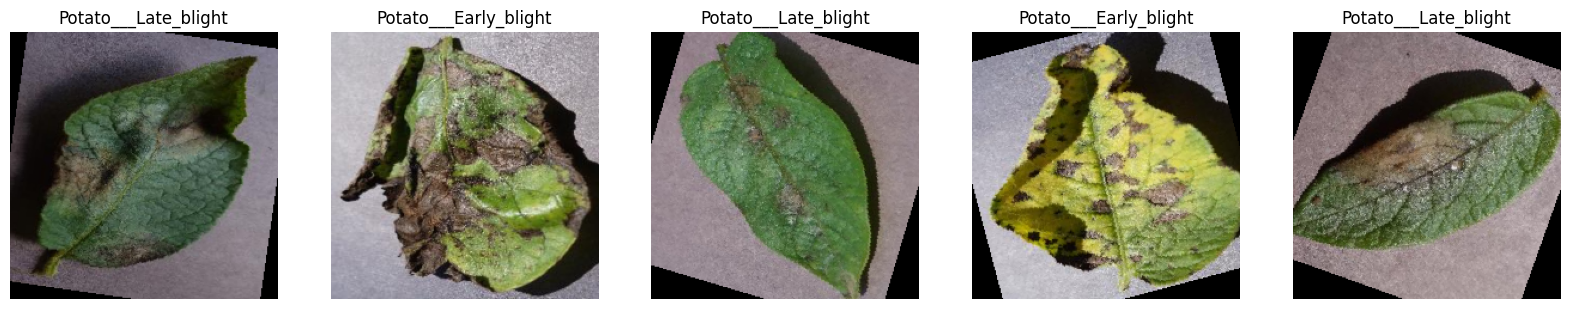

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define a function to display images
def show_images(images, labels, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(20, 5))
    for i in range(num_images):
        axes[i].imshow(np.transpose(images[i], (1, 2, 0)))
        axes[i].set_title(labels[i])
        axes[i].axis('off')
    plt.show()

# Get some sample images and labels from the dataset
num_images_to_display = 5
sample_indices = np.random.choice(len(dataset), num_images_to_display, replace=False)
sample_images = [dataset[i][0] for i in sample_indices]
sample_labels = [dataset.classes[dataset[i][1]] for i in sample_indices]

# Display the sample images with their labels
show_images(sample_images, sample_labels, num_images=num_images_to_display)


In [ ]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 16))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=12).permute(1, 2, 0))
        break

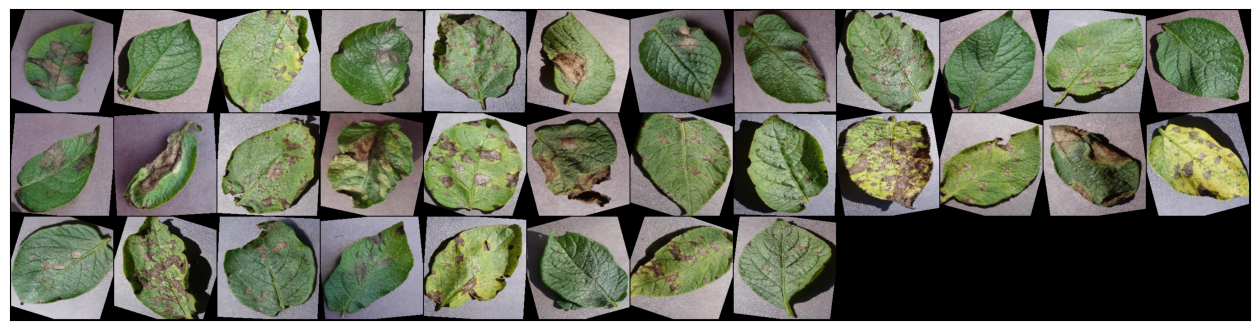

In [ ]:
show_batch(train_loader)

In [ ]:
import torch.nn.functional as F
import torch.nn as nn

class Base(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

        # print(f'Epoch: {epoch} | Train_loss: {result['train_loss']} | Val_loss:{result['val_loss']} | Val_acc: {result['val_acc']}')

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


In [ ]:
import torch.nn as nn

class PotatoDiseaseDetectionModel(Base):
    def __init__(self, in_channels=3, num_classes=3):
        super(PotatoDiseaseDetectionModel, self).__init__()

        # Define the network layers
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Flatten()
        )

        # Define the classifier layers
        self.classifier = nn.Sequential(
            nn.Linear(in_features=256*28*28, out_features=128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(in_features=128, out_features=num_classes)
        )

    def forward(self, x):
        # Pass the input through the network
        x = self.network(x)

        # Pass the output through the classifier
        x = self.classifier(x)

        return x


In [ ]:
# Create the model with desired number of classes
model = PotatoDiseaseDetectionModel(num_classes=3)
model

PotatoDiseaseDetectionModel(
  (network): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

num_params = count_parameters(model)
print(f"Number of parameters in the model: {num_params}")

Number of parameters in the model: 26838083


In [ ]:
from torch.nn import CrossEntropyLoss

for inputs, labels in train_loader:
    print("Inputs shape", inputs.shape)
    print("Labels shape", labels.shape)

    # Forward pass
    outputs = model(inputs)
    print("Output shape: ", outputs.shape)

    # Compute loss
    loss = CrossEntropyLoss()(outputs, labels)
    print("Loss:", loss.item())
    break

In [ ]:
import torch
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
to_device(model, device)

PotatoDiseaseDetectionModel(
  (network): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import accuracy_score

class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.delta = delta

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.best_score:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.Adam):
    history = []
    optimizer = opt_func(model.parameters(), lr=lr)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

    early_stopping = EarlyStopping(patience=5, verbose=True)

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)

        # LR Scheduler step
        scheduler.step(result['val_loss'])
        early_stopping(result['val_loss'], model)

        if early_stopping.early_stop:
            print("Early stopping")
            break

    return history


In [ ]:
evaluate(model, val_loader)

{'val_loss': 0.07999353110790253, 'val_acc': 0.9706845283508301}

In [ ]:
lr = 0.001
num_epochs = 20
opt_func = torch.optim.Adam

In [ ]:
%%time
history = fit(num_epochs, lr, model, train_loader, val_loader, opt_func)

Epoch [0], train_loss: 0.1195, val_loss: 0.5735, val_acc: 0.7937
Validation loss decreased (-0.573538 --> 0.573538).  Saving model ...
Epoch [1], train_loss: 0.1225, val_loss: 0.0856, val_acc: 0.9777
Validation loss decreased (-0.085648 --> 0.085648).  Saving model ...
Epoch [2], train_loss: 0.0987, val_loss: 4.8579, val_acc: 0.5582
EarlyStopping counter: 1 out of 5
Epoch [3], train_loss: 0.0898, val_loss: 0.2632, val_acc: 0.9012
EarlyStopping counter: 2 out of 5
Epoch [4], train_loss: 0.0656, val_loss: 0.7952, val_acc: 0.7147
EarlyStopping counter: 3 out of 5
Epoch [5], train_loss: 0.0754, val_loss: 0.2737, val_acc: 0.8903
Epoch 00006: reducing learning rate of group 0 to 1.0000e-04.
EarlyStopping counter: 4 out of 5
Epoch [6], train_loss: 0.0582, val_loss: 0.0391, val_acc: 0.9799
Validation loss decreased (-0.039054 --> 0.039054).  Saving model ...
Epoch [7], train_loss: 0.0402, val_loss: 0.0583, val_acc: 0.9754
EarlyStopping counter: 1 out of 5
Epoch [8], train_loss: 0.0384, val_los

In [ ]:
evaluate(model, val_loader)

{'val_loss': 0.036325711756944656, 'val_acc': 0.9866071343421936}

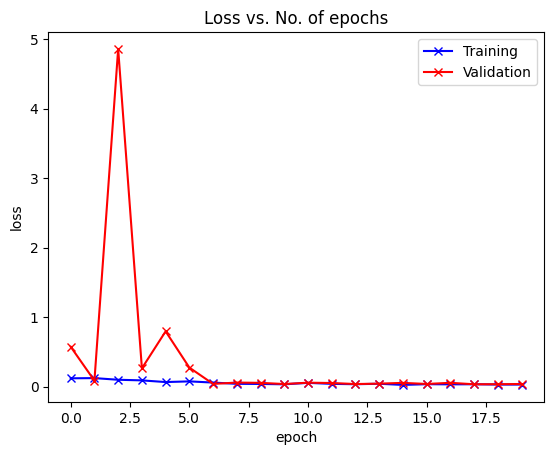

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
plot_losses(history)

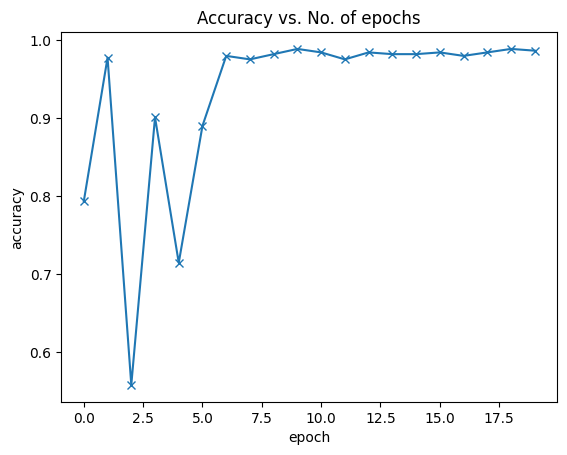

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
plot_accuracies(history)

In [ ]:
torch.save(model.state_dict(), 'potato_model_statedict__f.pth')

In [ ]:
def predict_image(img, model):
    # Convert the image to a torch tensor
    xb = to_device(img.unsqueeze(0), device)
    # Get the model's prediction
    yb = model(xb)
    # Pick the index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Get the class label
    return dataset.classes[preds[0].item()]


Label: Potato___Early_blight , Predicted: Potato___Early_blight


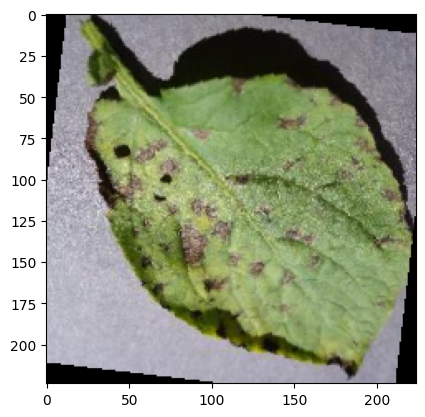

In [ ]:
img, label = val_set[0]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Path to image: /content/plant-village/PlantVillage/Potato___healthy/04481ca2-f94c-457e-b785-1ac05800b7ec___RS_HL 1930.JPG


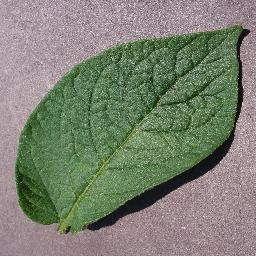

Predicted Class: Potato Healthy
Probability: 0.9883


In [ ]:
import torch
from torchvision import transforms as tt
from PIL import Image
import cv2
from google.colab.patches import cv2_imshow

# Define the transformations to be applied to the images
transforms = tt.Compose([
    tt.Resize((224, 224)),
    tt.RandomHorizontalFlip(p=0.5),
    tt.RandomVerticalFlip(p=0.5),
    tt.RandomRotation(20),
    tt.ToTensor()
])

# Load the image you want to predict
image_path = input("Path to image: ")  # Replace with the actual path to your image
image = Image.open(image_path).convert("RGB")
input_image = cv2.imread(image_path)

cv2_imshow(input_image)
# Pre-process the image
image_tensor = transforms(image).unsqueeze(0).to(device)

# Set the model to evaluation mode
model.eval()

# Make a prediction
with torch.no_grad():
    output = model(image_tensor)

# Convert the output to probabilities using softmax
probabilities = torch.nn.functional.softmax(output[0], dim=0)

# Get the predicted class
predicted_class = torch.argmax(probabilities).item()
class_labels = ['Potato Early Blight', 'Potato Late Blight', 'Potato Healthy']
# Get the probability for the predicted class
predicted_probability = probabilities[predicted_class].item()

# Print the prediction result
print(f"Predicted Class: {class_labels[predicted_class]}")
print(f"Probability: {predicted_probability:.4f}")
